In [88]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib as mpl
from mne.stats import permutation_cluster_test
from mne.stats import permutation_cluster_1samp_test
from functools import partial
from mne.stats import ttest_1samp_no_p, permutation_t_test,fdr_correction
from IPython.display import clear_output
from itertools import permutations,combinations



data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


trial_len = 2
remove_first = 0.5 #seconds

save_path = data_path + '/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)


Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


# coherence 

In [6]:
save_path = data_path + '/data/coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)

data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)

a = pd.DataFrame(data.reset_index())
freq = a.Freq.unique()
print(freq)

data.sample(10)


[ 1.49812734  1.99750312  2.4968789   2.99625468  3.49563046  3.99500624
  4.49438202  4.9937578   5.49313358  5.99250936  6.49188514  6.99126092
  7.4906367   7.99001248  8.48938826  8.98876404  9.48813983  9.98751561
 10.48689139 10.98626717 11.48564295 11.98501873 12.48439451 12.98377029
 13.48314607 13.98252185 14.48189763 14.98127341 15.48064919 15.98002497
 16.47940075 16.97877653 17.47815231 17.97752809 18.47690387 18.97627965
 19.47565543 19.97503121 20.47440699 20.97378277 21.47315855 21.97253433
 22.47191011 22.97128589 23.47066167 23.97003745 24.46941323 24.96878901
 25.46816479 25.96754057 26.46691635 26.96629213 27.46566792 27.9650437
 28.46441948 28.96379526 29.46317104 29.96254682 30.4619226  30.96129838
 31.46067416 31.96004994 32.45942572 32.9588015  33.45817728 33.95755306
 34.45692884 34.95630462 35.4556804  35.95505618 36.45443196 36.95380774
 37.45318352 37.9525593  38.45193508 38.95131086 39.45068664 39.95006242]


Data  \
Feature       Freq      Condition Delay Subject                                                       
TTCD          19.475655 All       0.2   Lucrezia  [0.027025906603555243, 0.0381591781619781, 0.0...   
lipProtrusion 4.993758  All       0.2   Pagani    [0.06807637005342529, 0.08633884569093686, 0.0...   
lipaparature  29.962547 All       0.2   Giada     [0.0026729861192152163, 0.013313546828619773, ...   
lipProtrusion 19.975031 All       0.2   Daniel    [0.015765925754976217, 0.02977450875996257, 0....   
              2.496879  All       0.2   Silvia2   [0.06356185169773566, 0.056502882685706746, 0....   
lipaparature  23.470662 All       0.2   Sara      [0.013601288378290083, 0.0023698729357778006, ...   
envelop       12.983770 All       0.2   Pagani    [0.00350228367723922, 0.04473292448171916, 0.0...   
TMCD          6.991261  All       0.2   Giorgia   [0.056982577507937955, 0.07006770078547934, 0....   
lipProtrusion 29.962547 All       0.2   Elena     [0.02975851089132854, 0.012415455119775034, 0....   
TTCD          28.464419 All       0.2   Lucrezia  [0.011633776915306022, 0.030471266056683596, 0...   

                                                  noTrials  Coherence  
Feature       Freq      Condition Delay Subject                        
TTCD          19.475655 All       0.2   Lucrezia       123   0.030788  
lipProtrusion 4.993758  All       0.2   Pagani         122   0.048624  
lipaparature  29.962547 All       0.2   Giada          121   0.015176  
lipProtrusion 19.975031 All       0.2   Daniel         122   0.022764  
              2.496879  All       0.2   Silvia2        118   0.076112  
lipaparature  23.470662 All       0.2   Sara           120   0.038492  
envelop       12.983770 All       0.2   Pagani         122   0.017491  
TMCD          6.991261  All       0.2   Giorgia        121   0.036470  
lipProtrusion 29.962547 All       0.2   Elena          121   0.018170  
TTCD          28.464419 All       0.2   Lucrezia       123   0.020737

Text(0.5,0.98,'EEG Delayed by 200 ms')

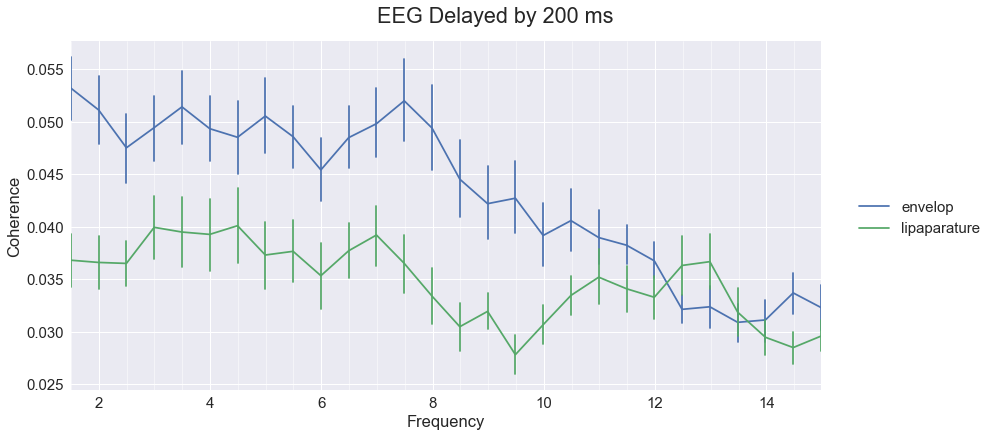

In [235]:
fi = []
for fr in range(0,len(iter_freqs)):
    fi.append(iter_freqs[fr][1])
    
a = pd.DataFrame(data.reset_index())
freq = a.Freq.unique()
fi = freq[freq <15]
#fi = freq[0:39:2]

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['All']

delay = [0.2]

a = data.loc[extra_channels,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
#sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 8})
#sns.set_style('darkgrid', {'grid.linewidth': .5,'axes.facecolor': '.9'})

g = sns.FacetGrid(a,  margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Freq", unit="Subject",condition="Feature", value="Coherence",
                    color="deep", err_style="ci_bars").add_legend()
b = b.set_xlabels('Frequency')
b = b.set_ylabels('Coherence')
b.ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
b.ax.grid(b=True, which='minor', color='w', linewidth=0.5)
b.fig.subplots_adjust(top=0.9)
b.fig.suptitle('EEG Delayed by 200 ms')


# surrogate coherence

In [98]:
save_path = data_path + '/data/1-12Hz_frequency_bands_in2hzStep_coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

# read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first)+'-envelop-lipaparature.pkl'
data_surrogate=pd.read_pickle(save_path)
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)
data_surrogate

Data  \
Feature      Freq       Condition Delay Subject                                                      
envelop      fr 1 - 3Hz All       0.2   Alice    [[0.05755803160841029, 0.012560136057659417, 0...   
             fr 4 - 6Hz All       0.2   Alice    [[0.056633624367644735, 0.01993660922797354, 0...   
lipaparature fr 1 - 3Hz All       0.2   Alice    [[0.010523410902331184, 0.036548788771247516, ...   
             fr 4 - 6Hz All       0.2   Alice    [[0.030278466779086792, 0.02724160015131158, 0...   

                                                 no_surrogates  
Feature      Freq       Condition Delay Subject                 
envelop      fr 1 - 3Hz All       0.2   Alice              123  
             fr 4 - 6Hz All       0.2   Alice              123  
lipaparature fr 1 - 3Hz All       0.2   Alice              123  
             fr 4 - 6Hz All       0.2   Alice              123

In [123]:
subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa']
subject_name= ['Alice']

features = ['envelop']
condition = ['All']
delay = [0.2]
freq_band = [ 'fr 1 - 3Hz']

A = data.loc[features,freq_band,condition,delay,subject_name]['Data'].get_values()
B = data_surrogate.loc[features,freq_band,condition,delay,subject_name]['Data'].get_values()
no_surrogates = data_surrogate.loc[features,freq_band,condition,delay,subject_name]['no_surrogates'].get_values()

p = [0] * 59
for ch in range(0,59):
    a = len(np.where(B[0][ch,:]<A[0][ch])[0])/no_surrogates
    p[ch] = a[0]

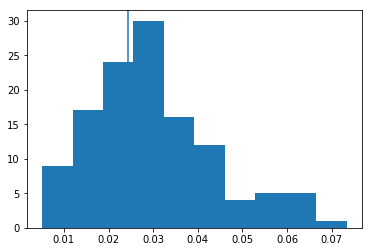

In [100]:
ch = 20
a = plt.hist(B[0][ch,:]) # plotting by columns
a = plt.axvline(x=A[0][ch]) # plotting by columns

In [96]:
subject_name = ['Alice']
features = ['envelop','lipaparature']
# putit into one file    
A=[]
a = ('-').join(features)
for s in subject_name:
    save_path = data_path + '/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'-'+s+'.pkl'
    A.append(pd.read_pickle(save_path))

data = pd.concat((A),axis=0)
save_path = data_path + '/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'.pkl'  
data.to_pickle(save_path)  
